# 1. Setup y carga de datos

En esta sección:
- Importamos librerías y configuramos estilo de gráficos.
- Cargamos el dataset y validamos estructura básica.
- Dejamos el dataframe listo para el análisis estadístico.

> Nota: A lo largo del notebook trabajaremos con `Attrition` como variable objetivo (Yes/No).

In [4]:
# ============================================================
# 1) Setup y carga de datos
# ============================================================

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency, mannwhitneyu

# --- Configuración básica de plots ---
plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.grid"] = False

# --- Carga del dataset ---
df = pd.read_csv("hr_processed.csv")

# --- Vista rápida ---
display(df.head())
print("Filas:", df.shape[0], "| Columnas:", df.shape[1])

# --- Comprobación de tipos y nulos (resumen) ---
display(df.dtypes.value_counts())
display(df.isna().mean().sort_values(ascending=False).head(15))

# --- Estandarizamos la variable objetivo por seguridad ---
df["attrition"] = df["attrition"].astype(str).str.strip()

print("Valores únicos en Attrition:", df["attrition"].unique())


,id,age,attrition,business_travel,daily_rate,department,distance_from_home,education,education_field,environment_satisfaction,...,performance_rating,relationship_satisfaction,stock_option_level,total_working_years,training_times_last_year,work_life_balance,years_at_company,years_in_current_role,years_since_last_promotion,years_with_curr_manager
0,1,41.0,Yes,Rarely,1102.0,Sales,1.0,Educación básica,Life Sciences,2.0,...,3.0,1.0,0.0,8.0,-4.440892e-16,Nada satisfecho,6.0,4.0,0.0,5.0
1,2,49.0,No,Frequently,279.0,Research & Development,8.0,Sin estudios,Life Sciences,3.0,...,4.0,4.0,1.0,10.0,3.000000e+00,Satisfecho,10.0,7.0,1.0,7.0
2,4,37.0,Yes,Rarely,1373.0,Research & Development,2.0,Educación básica,Other,4.0,...,3.0,2.0,0.0,7.0,3.000000e+00,Satisfecho,0.0,0.0,0.0,0.0
3,5,33.0,No,Frequently,1392.0,Research & Development,3.0,Estudios universitarios,Life Sciences,4.0,...,3.0,3.0,0.0,8.0,3.000000e+00,Satisfecho,8.0,7.0,3.0,0.0
4,7,27.0,No,Rarely,591.0,Research & Development,2.0,Sin estudios,Medical,1.0,...,3.0,4.0,1.0,6.0,3.000000e+00,Satisfecho,2.0,2.0,2.0,2.0


Filas: 1470 | Columnas: 31


float64    17
object     13
int64       1
Name: count, dtype: int64

id                          0.0
age                         0.0
attrition                   0.0
business_travel             0.0
daily_rate                  0.0
department                  0.0
distance_from_home          0.0
education                   0.0
education_field             0.0
environment_satisfaction    0.0
gender                      0.0
hourly_rate                 0.0
job_involvement             0.0
job_level                   0.0
job_role                    0.0
dtype: float64

Valores únicos en Attrition: ['Yes' 'No']


### Checklist técnico
- [ ] El dataset carga sin error.
- [ ] `Attrition` tiene exactamente dos valores (típicamente `Yes` y `No`).
- [ ] Revisamos rápidamente tipos de datos y posibles columnas con muchos nulos.

# 2. Baseline: tasa global de Attrition

Objetivo:
- Calcular la tasa global de attrition (benchmark) que usaremos como referencia.
- Ver el tamaño muestral total y el número de casos positivos (Attrition=Yes).

Justificación:
- Cualquier análisis por segmentos debe compararse contra el benchmark global para interpretar si un grupo presenta un riesgo mayor o menor que la media.

,count,rate_%
attrition,,
No,1233,83.88
Yes,237,16.12


Tasa global de Attrition (Yes): 16.12%


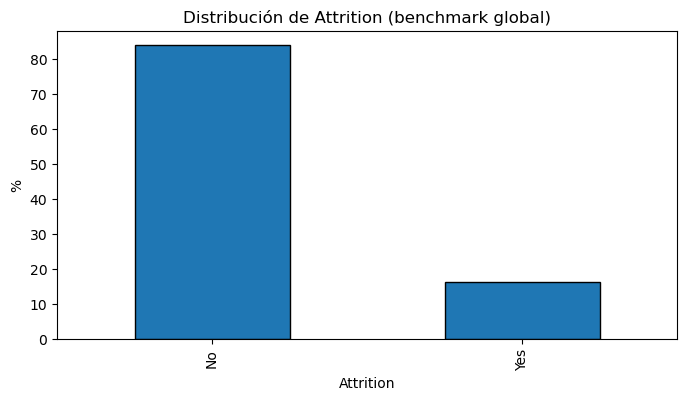

In [5]:
# ============================================================
# 2) Baseline de attrition
# ============================================================

# Conteo y porcentaje
counts = df["attrition"].value_counts(dropna=False)
rates = df["attrition"].value_counts(normalize=True, dropna=False) * 100

baseline = rates.get("Yes", np.nan)

display(pd.DataFrame({"count": counts, "rate_%": rates.round(2)}))

print(f"Tasa global de Attrition (Yes): {baseline:.2f}%")

# Visual rápido
rates.plot(kind="bar", edgecolor="black", linewidth=1)
plt.title("Distribución de Attrition (benchmark global)")
plt.ylabel("%")
plt.xlabel("Attrition")
plt.show()


### Conclusiones (Baseline de Attrition)

- El dataset analizado contiene un total de **1.470 empleados**.
- De ellos, **237 empleados** han abandonado la empresa, lo que representa una tasa global de attrition del **16,12%**.
- Los **1.233 empleados restantes (83,88%)** permanecen en la compañía.

Interpretación estadística:
- Esta tasa global de attrition se define como el **baseline** o valor de referencia del análisis.
- El baseline representa el comportamiento promedio del conjunto de empleados y sirve como punto de comparación para el análisis por segmentos.
- En las siguientes secciones, cualquier grupo o segmento con una tasa de attrition claramente superior al **16,12%** será considerado de **riesgo elevado**, mientras que valores inferiores indicarán un comportamiento más estable.


---
- Comentario Arantxa:
La última parte podría matizarse, ya que porcentajes elevados pueden aparecer en grupos con tamaños muestrales reducidos, lo que limita su interpretación
Además, hablar de “riesgo” implica inferencia estadística, y aún estás en esta fase el análisis es exploratorio; lo que vas a ver es más un indicador preliminar de concentración de bajas.
Podriamos ajustar la redacción a algo del estilo -> Esta tasa global (16,12%) se utiliza como baseline descriptivo para comparar segmentos del dataset. No obstante, la interpretación de tasas superiores o inferiores debe realizarse considerando el tamaño muestral de cada grupo y, cuando sea posible, evaluando su significancia estadística
---

# 3. Ranking estadístico de variables categóricas (priorización)

Objetivo:
- Identificar qué variables categóricas muestran mayor asociación con `attrition`.
- Priorizar variables para un análisis más profundo (descriptivo e inferencial).

Métricas usadas:
- **Chi-cuadrado (Chi²) + p-value**: evalúa si existe evidencia estadística de asociación.
- **Cramér’s V**: tamaño de efecto (fuerza de la asociación).
- **Diferencia de riesgo**: diferencia en puntos porcentuales entre el grupo con mayor y menor tasa de attrition.
- **n y nº de categorías**: control de calidad (evita conclusiones basadas en grupos muy pequeños).

Nota metodológica:
- Para estabilizar los resultados, las categorías con muy pocos casos se agrupan como **"other"** antes de calcular Chi² y Cramér’s V.

In [10]:
# =================================================================
# 3) Ranking estadístico: Chi² + Cramér's V + diferencia de riesgo
# =================================================================

def cramers_v_from_table(confusion_matrix: pd.DataFrame) -> float:
    """
    Calcula Cramér's V a partir de una tabla de contingencia.
    V está en [0, 1]. 0 = sin asociación, 1 = asociación muy fuerte.
    """
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.to_numpy().sum()
    if n == 0:
        return np.nan

    r, k = confusion_matrix.shape
    if min(r, k) <= 1:
        return np.nan

    v = np.sqrt((chi2 / n) / (min(r - 1, k - 1)))
    return float(v)


def build_attrition_ranking(
    df: pd.DataFrame,
    target: str = "attrition",
    yes_label: str = "yes",
    min_n_category: int = 30,
    max_unique_as_category: int = 20
) -> pd.DataFrame:
    """
    Genera un ranking para variables categóricas frente a attrition.

    - Agrupa categorías raras (< min_n_category) como 'other' para estabilizar.
    - Considera como categóricas:
        * columnas object/category/bool
        * columnas numéricas con pocos valores únicos (<= max_unique_as_category)

    Devuelve un DataFrame ordenado por:
    1) p-value ascendente
    2) Cramér's V descendente
    3) diferencia de riesgo descendente
    """
    data = df.copy()

    # Normalizamos target a minúsculas por seguridad
    data[target] = data[target].astype(str).str.strip().str.lower()

    # Columnas candidatas categóricas
    cat_cols = []

    for col in data.columns:
        if col == target:
            continue

        if (
            pd.api.types.is_object_dtype(data[col]) 
            or isinstance(data[col].dtype, pd.CategoricalDtype) 
            or pd.api.types.is_bool_dtype(data[col])
        ):
            cat_cols.append(col)

        else:
            # numéricas con pocos valores únicos -> tratarlas como categóricas
            nunique = data[col].nunique(dropna=True)
            if nunique <= max_unique_as_category:
                cat_cols.append(col)

    results = []

    for col in cat_cols:
        tmp = data[[col, target]].copy()

        # Convertimos a string (incluyendo NaNs como 'unknown')
        tmp[col] = tmp[col].astype("object").where(tmp[col].notna(), "unknown").astype(str).str.strip().str.lower()

        # Agrupamos categorías raras a 'other'
        counts = tmp[col].value_counts(dropna=False)
        rare = counts[counts < min_n_category].index
        tmp.loc[tmp[col].isin(rare), col] = "other"

        # Tabla de contingencia
        ct = pd.crosstab(tmp[col], tmp[target])

        # Si por cualquier motivo no hay columna yes/no, saltamos
        if ct.shape[1] < 2:
            continue

        # Chi²
        chi2, p_value, dof, expected = chi2_contingency(ct)

        # Cramér's V
        v = cramers_v_from_table(ct)

        # Diferencia de riesgo (max-min de tasa attrition)
        # Calculamos tasa de "yes" por categoría si existe yes_label
        if yes_label in ct.columns:
            rates = ct[yes_label] / ct.sum(axis=1)
            risk_diff = (rates.max() - rates.min()) * 100  # puntos porcentuales
        else:
            risk_diff = np.nan

        results.append({
            "variable": col,
            "n_total": int(ct.to_numpy().sum()),
            "n_categories": int(ct.shape[0]),
            "chi2": float(chi2),
            "p_value": float(p_value),
            "cramers_v": float(v),
            "risk_diff_pp": float(risk_diff)
        })

    ranking = pd.DataFrame(results)

    # Orden para priorizar: evidencia -> fuerza -> impacto práctico
    ranking = ranking.sort_values(
        by=["p_value", "cramers_v", "risk_diff_pp"],
        ascending=[True, False, False]
    ).reset_index(drop=True)

    return ranking


# Ejecutamos ranking
ranking = build_attrition_ranking(
    df=df,
    target="attrition",
    yes_label="yes",
    min_n_category=30,          # ajustable
    max_unique_as_category=20   # ajustable
)

display(ranking.head(20))
print("Variables evaluadas:", ranking.shape[0])


,variable,n_total,n_categories,chi2,p_value,cramers_v,risk_diff_pp
0,over_time,1470,2,88.336309,5.522049e-21,0.245138,20.347766
1,job_role,1470,9,86.190254,2.752482e-15,0.242142,37.259036
2,job_level,1470,5,72.529013,6.634685e-15,0.222125,21.618194
3,stock_option_level,1470,4,60.598301,4.379390e-13,0.203035,16.810769
4,years_in_current_role,1470,11,61.030065,2.312488e-09,0.203757,27.140255
5,marital_status,1470,4,42.468912,3.190479e-09,0.169972,14.877263
6,job_involvement,1470,4,28.492021,2.863181e-06,0.139220,24.707162
7,business_travel,1470,3,21.152252,2.551802e-05,0.119955,16.081735
8,environment_satisfaction,1470,4,22.503881,5.123469e-05,0.123729,11.899198
9,work_life_balance,1470,4,16.325097,9.725699e-04,0.105383,17.028275


Variables evaluadas: 20


### Conclusiones (Ranking estadístico de variables categóricas)

Se evaluaron un total de **20 variables categóricas** frente a la variable objetivo `attrition`, utilizando un enfoque combinado de evidencia estadística, tamaño de efecto e impacto práctico.

Principales hallazgos:

- **`over_time`** presenta la asociación más clara con la attrition:
  - p-value extremadamente bajo (≪ 0.001), lo que indica evidencia estadística muy sólida.
  - Cramér’s V = **0.245**, correspondiente a un tamaño de efecto moderado.
  - Diferencia de riesgo ≈ **20,3 puntos porcentuales**, lo que supone un impacto práctico elevado.

- **`job_role`** muestra la **mayor diferencia de riesgo** del ranking:
  - Diferencia de riesgo ≈ **37,3 puntos porcentuales**.
  - Cramér’s V = **0.242**, indicando una relación fuerte a nivel práctico.
  - Aunque es una variable estructural, identifica perfiles claramente diferenciados en términos de riesgo de salida.

- **`job_level`** y **`stock_option_level`** también presentan asociaciones estadísticamente significativas:
  - Tamaños de efecto moderados (Cramér’s V entre **0.20 y 0.22**).
  - Diferencias de riesgo superiores a **16 puntos porcentuales**, lo que justifica un análisis más detallado.

- Variables relacionadas con la experiencia y la progresión, como **`years_in_current_role`** y **`years_since_last_promotion`**, muestran asociaciones relevantes, aunque con tamaños de efecto ligeramente inferiores.

- Variables de satisfacción (`job_involvement`, `work_life_balance`, `job_satisfaction`, `environment_satisfaction`) presentan:
  - Evidencia estadística significativa.
  - Tamaños de efecto bajos a moderados.
  - Impacto práctico no despreciable, pero inferior a las variables líderes del ranking.

Conclusión metodológica:
- El ranking permite priorizar variables combinando significación estadística y relevancia práctica.
- Las variables con **mayor Cramér’s V y mayor diferencia de riesgo** se consideran candidatas prioritarias para un análisis en profundidad en las siguientes secciones.


--- 
Comentario Arantxa:
- Dejar fuera las variables numéricas puede sesgar el análisis. Algunas de ellas tienen más asociación (y significativa) que varias categóricas, así que al no incluirlas estamos viendo una foto parcial y la priorización que haces luego queda distorsionada.
- En las conclusiones vigilaría la interpretación de Cramér’s V. Por ejemplo, el 0.242 de job_role es más bien pequeño-moderado; no indicaría una relación fuerte a nivel práctico.
- Y otra cosilla: years_in_current_role y years_since_last_promotion aparecen juntas como relevantes, pero solo la primera es significativa. Mejor separarlas para no presentar ambas como hallazgos cuando estadísticamente no lo son.
--- 

## 3.1 Selección de variables para análisis en profundidad (Deep Dive)

Tras construir el ranking estadístico, seleccionamos un subconjunto reducido de variables para un análisis más detallado.

Justificación metodológica:
- En datasets con muchas variables, es necesario **priorizar** para evitar conclusiones dispersas.
- Para priorizar, combinamos tres criterios complementarios:
  1. **Evidencia estadística (p-value, Chi²)**: indica si la asociación observada podría atribuirse al azar.
  2. **Tamaño de efecto (Cramér’s V)**: cuantifica la intensidad de la asociación (relevancia estadística práctica).
  3. **Impacto práctico (diferencia de riesgo, en puntos porcentuales)**: mide cuánto puede variar la tasa de attrition entre segmentos.

Criterio de selección:
- Seleccionaremos variables que cumplan al menos uno de estos umbrales (regla de priorización):
  - **Cramér’s V ≥ 0.20** (asociación al menos moderada), y/o
  - **Diferencia de riesgo ≥ 20 puntos porcentuales** (impacto práctico elevado).
- Además, se revisa la calidad del segmentado:
  - número razonable de categorías (`n_categories`) y
  - estabilidad del análisis (evitando categorías extremadamente pequeñas mediante agrupación previa).

Con este criterio se busca un equilibrio entre:
- rigor estadístico (no quedarse solo con p-values),
- relevancia práctica (no quedarse solo con tamaños de efecto),
- y claridad para la demo (foco en pocos factores bien justificados).


In [11]:
# ============================================================
# 3.1) Selección de variables para Deep Dive
# ============================================================

# Umbrales
V_THRESHOLD = 0.20
RISK_THRESHOLD = 20.0

selected = ranking[
    (ranking["cramers_v"] >= V_THRESHOLD) | (ranking["risk_diff_pp"] >= RISK_THRESHOLD)
].copy()

# Variables con p-value muy bajo pero efecto débil (útiles para comentar por qué NO se eligen)
weak_effect = ranking[
    (ranking["p_value"] < 0.05) & (ranking["cramers_v"] < 0.10) & (ranking["risk_diff_pp"] < 10)
].copy()

display(selected[["variable", "p_value", "cramers_v", "risk_diff_pp", "n_categories"]].head(10))
print("Variables seleccionadas (criterio):", selected.shape[0])

display(weak_effect[["variable", "p_value", "cramers_v", "risk_diff_pp", "n_categories"]].head(10))
print("Variables con significación pero efecto débil (ejemplos):", weak_effect.shape[0])


,variable,p_value,cramers_v,risk_diff_pp,n_categories
0,over_time,5.522049e-21,0.245138,20.347766,2
1,job_role,2.752482e-15,0.242142,37.259036,9
2,job_level,6.634685e-15,0.222125,21.618194,5
3,stock_option_level,4.379390e-13,0.203035,16.810769,4
4,years_in_current_role,2.312488e-09,0.203757,27.140255,11
6,job_involvement,2.863181e-06,0.139220,24.707162,4


Variables seleccionadas (criterio): 6


,variable,p_value,cramers_v,risk_diff_pp,n_categories
13,department,0.01074,0.07854,6.223762,3


Variables con significación pero efecto débil (ejemplos): 1


### Conclusiones (Selección para Deep Dive)

Se aplicó un criterio de priorización basado en tres dimensiones:
1) evidencia estadística (p-value del test Chi²),
2) tamaño de efecto (Cramér’s V),
3) impacto práctico (diferencia de riesgo en puntos porcentuales).

Umbrales usados:
- **Cramér’s V ≥ 0.20** (asociación al menos moderada) y/o
- **diferencia de riesgo ≥ 20 pp** (variación práctica relevante entre segmentos).

Resultado:
- Se seleccionan **6 variables** como candidatas prioritarias para análisis en profundidad:
  - `over_time` (V=0.245; diff≈20.35 pp; p≈5.5e-21)
  - `job_role` (V=0.242; diff≈37.26 pp; p≈2.8e-15)
  - `job_level` (V=0.222; diff≈21.62 pp; p≈6.6e-15)
  - `stock_option_level` (V=0.203; diff≈16.81 pp; p≈4.4e-13) [seleccionada por tamaño de efecto]
  - `years_in_current_role` (V=0.204; diff≈27.14 pp; p≈2.3e-09)
  - `job_involvement` (V=0.139; diff≈24.71 pp; p≈2.9e-06) [seleccionada por impacto práctico]

Justificación de exclusión:
- Se observa al menos una variable con p-value < 0.05 pero **efecto débil** y **bajo impacto práctico**, como `department` (V≈0.079; diff≈6.22 pp).
- Esto refuerza que el p-value por sí solo no mide relevancia: se

# 4. Deep Dive 1 — `over_time` y su relación con `attrition`

Objetivo:
- Cuantificar cómo varía la tasa de attrition entre empleados con y sin horas extra (`over_time`).
- Validar estadísticamente si la relación observada es consistente mediante un test Chi².

Justificación:
- `over_time` aparece como variable prioritaria en el ranking por:
  - p-value extremadamente bajo (evidencia sólida),
  - Cramér’s V moderado,
  - y una diferencia de riesgo elevada (≈ 20 pp).
- Al ser una variable categórica con 2 niveles, permite una comparación directa e interpretable.

attrition,no,yes
over_time,,
No,953,112
Yes,280,125


,attrition_rate_%
over_time,
Yes,30.86
No,10.52


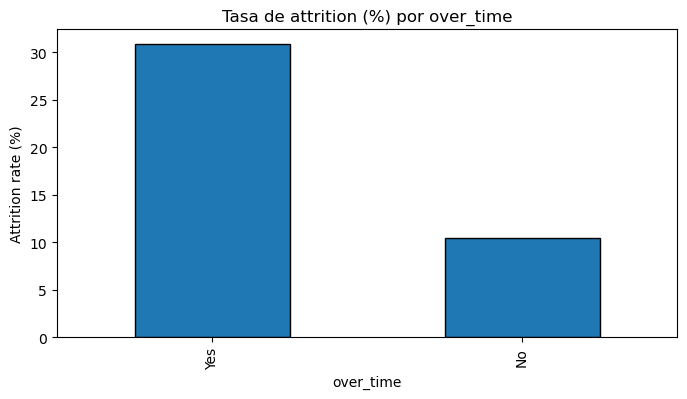

Chi² = 88.336 | dof = 1 | p-value = 5.522e-21
Cramér's V = 0.245
Diferencia de riesgo = 20.35 puntos porcentuales


In [13]:
# ============================================================
# 4) Deep Dive 1: over_time vs attrition (robusto a Yes/No)
# ============================================================

tmp = df.copy()

# Normalizamos target (evita errores tipo 'yes' vs 'Yes')
tmp["attrition"] = tmp["attrition"].astype(str).str.strip().str.lower()

# 1) Tabla de contingencia
ct_ot = pd.crosstab(tmp["over_time"], tmp["attrition"])
display(ct_ot)

# Aseguramos que existe la columna 'yes'
if "yes" not in ct_ot.columns:
    raise ValueError(f"No existe la categoría 'yes' en attrition. Columnas disponibles: {list(ct_ot.columns)}")

# 2) Tasas de attrition por grupo (en %)
attr_rate_ot = (ct_ot["yes"] / ct_ot.sum(axis=1) * 100).sort_values(ascending=False)
display(attr_rate_ot.round(2).to_frame(name="attrition_rate_%"))

# 3) Gráfico
ax = attr_rate_ot.plot(kind="bar", edgecolor="black", linewidth=1)
ax.grid(False)
plt.title("Tasa de attrition (%) por over_time")
plt.ylabel("Attrition rate (%)")
plt.xlabel("over_time")
plt.show()

# 4) Chi² + p-value
chi2, p_value, dof, expected = chi2_contingency(ct_ot)
print(f"Chi² = {chi2:.3f} | dof = {dof} | p-value = {p_value:.3e}")

# 5) Cramér’s V
v_ot = cramers_v_from_table(ct_ot)
print(f"Cramér's V = {v_ot:.3f}")

# 6) Diferencia de riesgo (pp)
risk_diff_ot = (attr_rate_ot.max() - attr_rate_ot.min())
print(f"Diferencia de riesgo = {risk_diff_ot:.2f} puntos porcentuales")


### Conclusiones (Deep Dive 1 — over_time)

**Resultados descriptivos**
- En el grupo `over_time = Yes`, la tasa de attrition es **30,86%** (125 salidas de 405 empleados).
- En el grupo `over_time = No`, la tasa de attrition es **10,52%** (112 salidas de 1.065 empleados).
- La **diferencia de riesgo** entre ambos grupos (máximo − mínimo) es de **20,35 puntos porcentuales**, lo que indica una variación práctica elevada entre segmentos.

**Comparación con el benchmark global**
- El baseline global es **16,12%**.
- `over_time = Yes` está **muy por encima** del baseline (30,86% vs 16,12%).
- `over_time = No` está **por debajo** del baseline (10,52% vs 16,12%).

**Resultados inferenciales**
- Test de independencia Chi²: **Chi² = 88,34**, **dof = 1**, **p-value = 5,52e−21**.
  - Interpretación: existe **evidencia estadística extremadamente sólida** para rechazar la hipótesis de independencia; `over_time` y `attrition` están asociadas.
- Tamaño de efecto (Cramér’s V): **V = 0,245**.
  - Interpretación: asociación de **magnitud moderada**, consistente con una relación relevante en términos estadísticos y prácticos.

**Conclusión estadística**
- `over_time` presenta una asociación estadísticamente significativa con `attrition` (p ≪ 0,05), con tamaño de efecto moderado y una diferencia de riesgo elevada, por lo que se considera una variable prioritaria para profundizar en el análisis de segmentos.